In [ ]:
!pip install --upgrade xgboost scikit-learn
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Introduction

This project tackles the kaggle playground challenge of predicting road accident risk. The goal is to build a model that predicts accident_risk a continuous value between 0 and 1 based on features like road conditions, weather, and time. A successful model can help identify high risk scenarios, allowing for targeted safety interventions to make roads safer.

Since the target is a continuous value, this is a regression problem. We will use the XGBoost Regressor, a powerful gradient-boosting algorithm well-suited for this kind of tabular data. This notebook will document the full process, starting with exploratory data analysis (EDA) to understand the data and guide our preprocessing steps.

In [3]:
data_train_path = '/kaggle/input/playground-series-s5e10/train.csv'
data_test_path = '/kaggle/input/playground-series-s5e10/test.csv'

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)

data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

# EDA #
Next we'll continue in this vain of looking at the data to better understand the data moving forward. This is a crucial step to understand the data's structure, relationships ( between the features and targets ), and find any potential issues. We'll start looking at the target variable to confirm what we've seen above.

In [4]:
target = 'accident_risk'
data_train[target].describe()

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64

<Axes: >

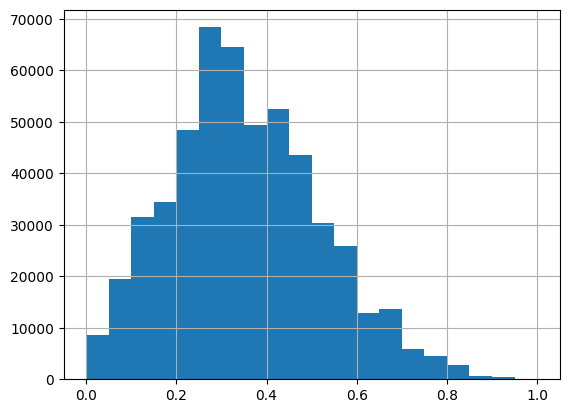

In [5]:
data_train[target].hist(bins = 20)

Next up let's look at the numerical features:

In [6]:
bool_features = ['road_signs_present', 'public_road', 'holiday', 'school_season']
num_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
cat_features = ['road_type', 'lighting', 'weather', 'time_of_day']

data_train[num_features].describe()

,num_lanes,curvature,speed_limit,num_reported_accidents
count,517754.000000,517754.000000,517754.000000,517754.000000
mean,2.491511,0.488719,46.112575,1.187970
std,1.120434,0.272563,15.788521,0.895961
min,1.000000,0.000000,25.000000,0.000000
25%,1.000000,0.260000,35.000000,1.000000
50%,2.000000,0.510000,45.000000,1.000000
75%,3.000000,0.710000,60.000000,2.000000
max,4.000000,1.000000,70.000000,7.000000


In [7]:
data_train[bool_features].describe()

,road_signs_present,public_road,holiday,school_season
count,517754,517754,517754,517754
unique,2,2,2,2
top,False,True,True,False
freq,259289,260045,260688,260164


Now let's look at the categorical features:

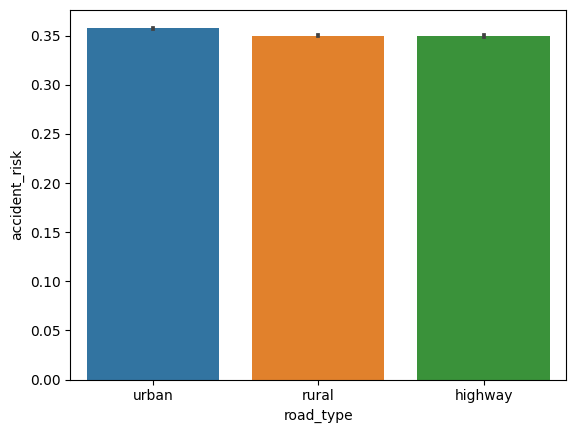

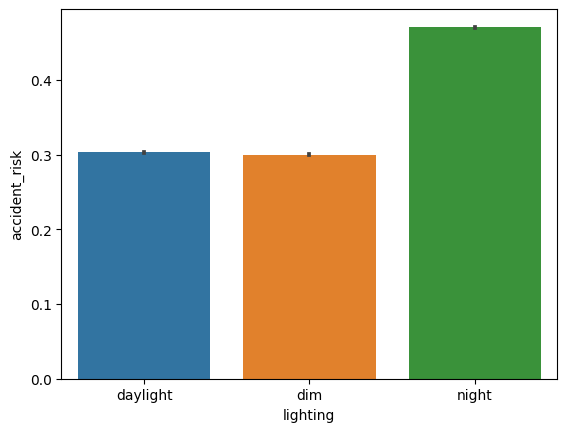

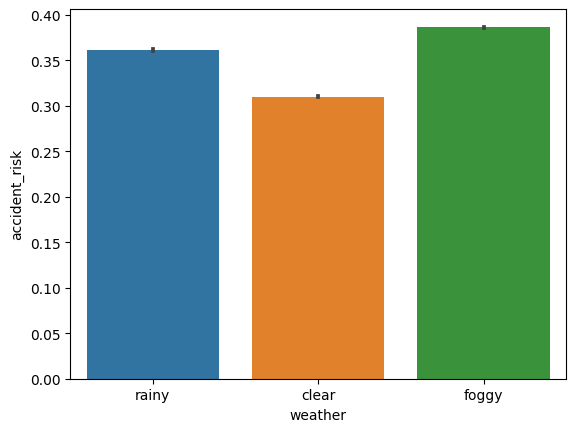

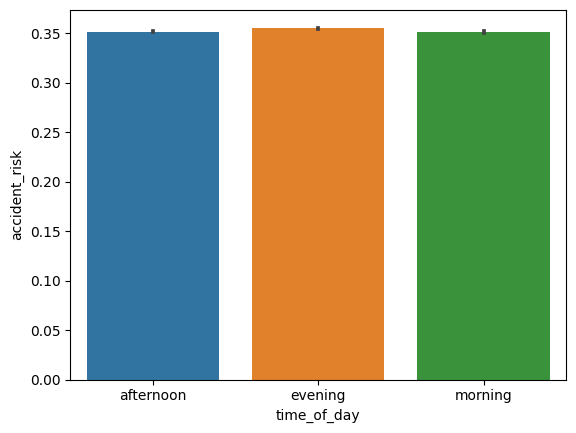

In [8]:
for col in cat_features:
    sns.barplot(data = data_train, x = col, y = target)
    plt.show()

# Data Processing and Feature Engineering

## Data Processing
The first step is to clean and format the raw data.
* Missing Values: A check with .info() confirms the dataset is complete, with no null values. This is great news, as it means we don't need to perform imputation or drop any data.
* Boolean features: The boolean features are converted from True/False to their integer equivalents 1/0.
* Categorical features: The categorical features are OHEd through a pipeline and column tranformer

## Feature Engineering
To help the model find more complex patterns, we create several new features from the existing data.
* accidents_per_lane: We create a ratio to get a measure of accident density. This is more predictive than just the raw accident count.
* weather_and_time: We create an interaction feature to capture the combined risk of these two conditions.
* square_speed: We create a polynomial feature to help the model capture the non-linear relationship between speed and risk, as risk often increases exponentially with speed.

In [9]:
def new_features(df):
    df_new = df.copy()

    df_new['accidents_per_lane'] = df_new['num_reported_accidents'] / (df_new['num_lanes'])
    df_new['weather_and_time'] = df_new['weather'] + df_new['time_of_day']
    df_new['square_speed'] = df_new['speed_limit'] ** 2

    return df_new

y_train = data_train[target]
x_train = data_train.drop(columns = ['id', target])

ids = data_test['id']
x_test = data_test.drop(columns = ['id'])

for col in bool_features:
    x_train[col] = x_train[col].astype(int)
    x_test[col] = x_test[col].astype(int)

x_train = new_features(x_train)
x_test = new_features(x_test)

num_features.extend(['accidents_per_lane', 'square_speed'])
cat_features.append('weather_and_time')
features = num_features + bool_features

cat_transformer = Pipeline(steps = [
    ('OH', OneHotEncoder(handle_unknown = 'ignore', drop = 'first', sparse_output = False))
])

preproc = ColumnTransformer(
    transformers = [
        ('OH', cat_transformer, cat_features),
        ('pass', 'passthrough', features)
    ], 
    remainder = 'drop')

# Hyperparameter Tuning with Optuna

Instead of guessing parameters manually, Optuna automates the search. We define an objective function where, for each trial, Optuna:
1.  Suggests a new combination of hyperparameters (learning_rate, max_depth, etc).
2.  Runs our entire 10-fold cross-validation loop using those parameters.
3.  Receives the final, reliable oof rmses score from that CV.

Optuna repeats this process 25 times, learning from each trial to make smarter guesses.

In [ ]:
def objective(trial):
    
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 2000,
        'early_stopping_rounds': 50,
        'n_jobs': -1,
        'random_state': 3,
        
        'tree_method': 'hist',
        'device': 'cuda',

        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    folds = 10
    kf = KFold(n_splits = folds, shuffle = True, random_state = 1)

    oof_preds = np.zeros(x_train.shape[0])
    fold_scores = []

    for fold, (train_id, val_id) in enumerate(kf.split(x_train, y_train)):

        x_train_fold = x_train.iloc[train_id]
        y_train_fold = y_train.iloc[train_id]
        x_val_fold = x_train.iloc[val_id]
        y_val_fold = y_train.iloc[val_id]

        x_train_proc = preproc.fit_transform(x_train_fold)
        x_val_proc = preproc.transform(x_val_fold)
        
        model = xgb.XGBRegressor(**params)

        model.fit(x_train_proc, y_train_fold,
            eval_set = [(x_val_proc, y_val_fold)],
            verbose = False
        )
        
        val_preds = model.predict(x_val_proc)
        oof_preds[val_id] = val_preds
        
        rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
        fold_scores.append(rmse)
    
    final_oof_rmse = np.sqrt(mean_squared_error(y_train, oof_preds))
    
    trial.report(final_oof_rmse, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return final_oof_rmse


study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 25)

best_params = study.best_params
print(best_params)

# Final Model Training and Evaluation

We run our 10-fold cross-validation loop one last time. This isn't for tuning; this is to generate our final predictions.

1.  Generates final predictions: Each of the 10 models, trained on its fold, makes predictions on the test set. We average all 10 of these predictions to create a single, robust test_preds_final. 

2.  Confirms final score: We get a final (mean) rmse from this run. This score is our best and most reliable estimate of how our model will perform on new, unseen data.

[0]	validation_0-rmse:0.16480
[500]	validation_0-rmse:0.05587
[611]	validation_0-rmse:0.05587
[0]	validation_0-rmse:0.16465
[500]	validation_0-rmse:0.05598
[573]	validation_0-rmse:0.05598
[0]	validation_0-rmse:0.16433
[500]	validation_0-rmse:0.05665
[569]	validation_0-rmse:0.05665
[0]	validation_0-rmse:0.16461
[500]	validation_0-rmse:0.05620
[602]	validation_0-rmse:0.05620
[0]	validation_0-rmse:0.16436
[500]	validation_0-rmse:0.05592
[588]	validation_0-rmse:0.05592
[0]	validation_0-rmse:0.16487
[500]	validation_0-rmse:0.05570
[524]	validation_0-rmse:0.05570
[0]	validation_0-rmse:0.16440
[500]	validation_0-rmse:0.05633
[568]	validation_0-rmse:0.05633
[0]	validation_0-rmse:0.16393
[500]	validation_0-rmse:0.05639
[542]	validation_0-rmse:0.05639
[0]	validation_0-rmse:0.16396
[500]	validation_0-rmse:0.05553
[591]	validation_0-rmse:0.05553
[0]	validation_0-rmse:0.16430
[500]	validation_0-rmse:0.05581
[534]	validation_0-rmse:0.05581
0.0560359289031301


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

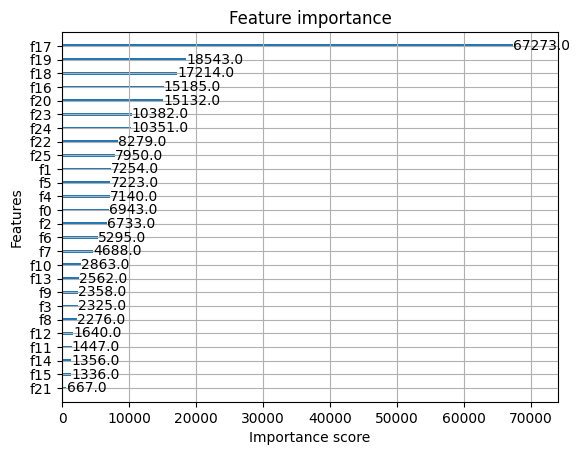

In [11]:
best_params['objective'] = 'reg:squarederror'
best_params['n_estimators'] = 3000
best_params['early_stopping_rounds'] = 50
best_params['n_jobs'] = -1
best_params['random_state'] = 4
best_params['tree_method'] = 'hist'
best_params['device'] = 'cuda'

folds = 10
kf = KFold(n_splits = folds, shuffle = True, random_state = 5)

oof_preds_final = np.zeros(x_train.shape[0])
test_preds_final = np.zeros(x_test.shape[0])
final_fold_scores = []

for fold, (train_id, val_id) in enumerate(kf.split(x_train, y_train)):
    
    x_train_fold = x_train.iloc[train_id]
    y_train_fold = y_train.iloc[train_id]
    x_val_fold = x_train.iloc[val_id]
    y_val_fold = y_train.iloc[val_id]

    x_train_proc = preproc.fit_transform(x_train_fold)
    x_val_proc = preproc.transform(x_val_fold)
    x_test_proc_fold = preproc.transform(x_test)

    model = xgb.XGBRegressor(**best_params)
    
    model.fit(x_train_proc, y_train_fold,
        eval_set = [(x_val_proc, y_val_fold)],
        verbose = 500
    )
    
    val_preds = model.predict(x_val_proc)
    oof_preds_final[val_id] = val_preds
    
    rmse = np.sqrt(mean_squared_error(y_val_fold, val_preds))
    final_fold_scores.append(rmse)

    test_preds_final += model.predict(x_test_proc_fold) / folds


rmse = np.mean(final_fold_scores)
print(rmse)
xgb.plot_importance(model)

# Conclusion

And there we go! This project successfully built a complete, high-performance pipeline for predicting road accident risk.

We began with a simple model, established a reliable baseline RMSE of 0.05619 using KFold cross validation, and then performed automated hyperparameter tuning with Optuna to find the best possible settings for our model.

Our final, tuned model achieved an rmse of 0.05603.

This is a very strong and complete result. While there are always more steps to take, we have successfully moved from a simple baseline to a fully optimized and robust machine learning solution.

In [12]:
sub = pd.DataFrame({'id': ids, 'accident_risk': test_preds_final})
sub.to_csv('submission.csv', index = False)